## In this file, we show a simple example on how to use deep convolutional neural network to classify raw EEG signals.

### Step 1: Load EEG signals. 

> We load the EEG Motor Movement/Imagery Dataset (https://physionet.org/content/eegmmidb/1.0.0/)

> We will only load parts of the "task 3" data for simplicity  (open and close both fists or both feet)

> We use sliding window methods to augument the data 

This tutorial uses the MNE open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.

In [1]:
!pip install mne

In [2]:
# Essential libraries used for loading the dataset
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
import numpy as np

In [43]:
#Get epochs with sliding window 
def getEpochs(subjects, runs, event_id):
    # set your path to save the dataset
    dataset_path = './EEGBCI_dataset'
    tmin, tmax = -1., 4. 
    subject_row = []

    for subject in subjects:
        raw_fnames = eegbci.load_data(subject, runs, dataset_path)
        #concatenate multiply runs into one instance
        subject_row.append(concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]))
    raw = concatenate_raws([row for row in subject_row])

    eegbci.standardize(raw)
    # set channel names standard_1005
    montage = make_standard_montage('standard_1005') # Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
    raw.set_montage(montage)

    #Strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    #Apply band-pass filter 
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')  # band pass filter 
    
    #Get events from raw signal 
    events, _ = events_from_annotations(raw, event_id=event_id)

    #Choose only EEG signals 
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

    #Get epochs from raw data  
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

    epochs_data = epochs.get_data()
    labels = epochs.events[:, -1] - 1
        
    return epochs_data, labels

In [44]:
%%capture
#Load task 3 data 
#The data will automatically start download if you don't have it in the path you set 
# Note: It might take a while to download the data
#Choose subjects id from 1 to 20 
subjects = [i for i in range(1, 21)]

#Choose all task 3 runs 
task3_runs = [5, 9, 13]

#Set task event id
task3_event_id = dict(T1=1, T2=2) #T1 open fists, T2 open feet

#Get all task3 epoch data and its corresponding labels 
task3_epochs_data, task3_labels = getEpochs(subjects, task3_runs, task3_event_id)

In [45]:
#Take a look at the data and label size
print(task3_epochs_data.shape)
print(task3_labels.shape)

(888, 64, 801)
(888,)


In [46]:
# We have 888 samples, each sample can be viewed as a 2D matrix where the height 64 represents EEG data channels, 
# the width 801 represents there are 801 time points in one event. 

### Step 2: Create a Deep convolutional neural network specially designed for EEG data classification

In [36]:
#Check GPU availablity
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
# tools for plotting graphs
from matplotlib import pyplot as plt

In [38]:
#Control GPU memory growth
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True # Allow memory allocation to grow beyond the initial default size
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [39]:
#Keras models
import tensorflow.keras as keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, Cropping2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Reshape
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

In [40]:
#Change the channel order as required in EEGNet paper 
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

#build the model
def EEG_ConvNet(nb_classes, Chans = 64, Samples = 160, dropoutRate = 0.5):

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(30, (1, 8),   # Convolution along time with filters of size [1 x 8]
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(30, (Chans, 1), use_bias=False, # Convolution accross channels with filters of size [#channels x 1]
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    # We use the The exponential linear unit (ELU) activation function 
    block1       = Activation('elu')(block1) 
    block1       = MaxPooling2D(pool_size=(1, 8), strides=(1, 3))(block1)
    block1       = Activation('elu')(block1)
    block1       = Dropout(dropoutRate)(block1)
    
    block2       = Conv2D(50, (1, 3),   # Convolution along time with filters of size [1 x 3]
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 4), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    flatten      = Flatten()(block2)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [41]:
number_classes = 2
model = EEG_ConvNet(2)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 64, 160)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 64, 153)       270       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 1, 153)        57600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 1, 153)        120       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 1, 153)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 1, 49)         0         
_________________________________________________________________
activation_9 (Activation)    (None, 30, 1, 49)         0   

### Step 3: Train the EEG_ConvNet model with the EEG data we have loaded

In [47]:
def train(X_train, Y_train, X_val, Y_val, model, batch_size = 128, epochs = 100, filename = 'results'):
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filename+"Rand42.h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
    ]
    
    
    fittedModel = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data=(X_val, Y_val), 
                       callbacks = callbacks)
    return fittedModel
    

In [48]:
#Function for plotting the training accuracy and training loss
def training_plots(fittedModel, epochs):
    loss = fittedModel.history['loss']
    val_loss = fittedModel.history['val_loss']
    
    acc = fittedModel.history['accuracy']
    val_acc = fittedModel.history['val_accuracy']
    
    plt.rcParams["figure.figsize"] = (20,10)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    
    num_epochs = range(epochs)
    ax1.plot(num_epochs, loss, 'r', label='Training loss')
    ax1.plot(num_epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(num_epochs, acc, 'r', label='Training acc')
    ax2.plot(num_epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('acc')
    ax2.legend()
    
    plt.show()

In [50]:
from sklearn.model_selection import train_test_split

#Reshape the data and split train validation test sets
chans = 64
samples = 801
X_train = task3_epochs_data.reshape(task3_epochs_data.shape[0], 1, chans, samples).astype("float32") * 10000
X_train = X_train[:,:,:,:-1]

# Sprlit 1: split the original dataset into training and test parts (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, task3_labels, test_size=0.2, random_state=42)

# Sprlit 2: Further split the training part from split 1 into a training and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [51]:
print(f'X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}, X_val.shape = {X_val.shape}')

X_train.shape = (568, 1, 64, 800), X_test.shape = (178, 1, 64, 800), X_val.shape = (142, 1, 64, 800)


In [54]:
#Creat a EEG_ConvNet model and train it
n_epochs = 100 # For how many epochs to train
model = EEG_ConvNet(nb_classes = 2, Chans = 64, Samples = 800, dropoutRate = 0.5)
fittedmodel = train(X_train, Y_train, X_val, Y_val, model, epochs = n_epochs, filename = 'EEG_ConvNettask3')

Epoch 1/100
5/5 - 3s - loss: 0.9401 - accuracy: 0.5106 - val_loss: 0.7271 - val_accuracy: 0.4930
Epoch 2/100
5/5 - 0s - loss: 0.8790 - accuracy: 0.5352 - val_loss: 0.7001 - val_accuracy: 0.5211
Epoch 3/100
5/5 - 0s - loss: 0.8314 - accuracy: 0.5317 - val_loss: 0.6975 - val_accuracy: 0.5211
Epoch 4/100
5/5 - 0s - loss: 0.8476 - accuracy: 0.5458 - val_loss: 0.6833 - val_accuracy: 0.5493
Epoch 5/100
5/5 - 0s - loss: 0.7678 - accuracy: 0.5704 - val_loss: 0.6761 - val_accuracy: 0.6338
Epoch 6/100
5/5 - 0s - loss: 0.7627 - accuracy: 0.5352 - val_loss: 0.6747 - val_accuracy: 0.5986
Epoch 7/100
5/5 - 0s - loss: 0.7056 - accuracy: 0.5669 - val_loss: 0.6890 - val_accuracy: 0.5634
Epoch 8/100
5/5 - 0s - loss: 0.7261 - accuracy: 0.5704 - val_loss: 0.6719 - val_accuracy: 0.6197
Epoch 9/100
5/5 - 0s - loss: 0.7091 - accuracy: 0.5616 - val_loss: 0.6692 - val_accuracy: 0.5986
Epoch 10/100
5/5 - 0s - loss: 0.6867 - accuracy: 0.6109 - val_loss: 0.6677 - val_accuracy: 0.5986
Epoch 11/100
5/5 - 0s - loss:

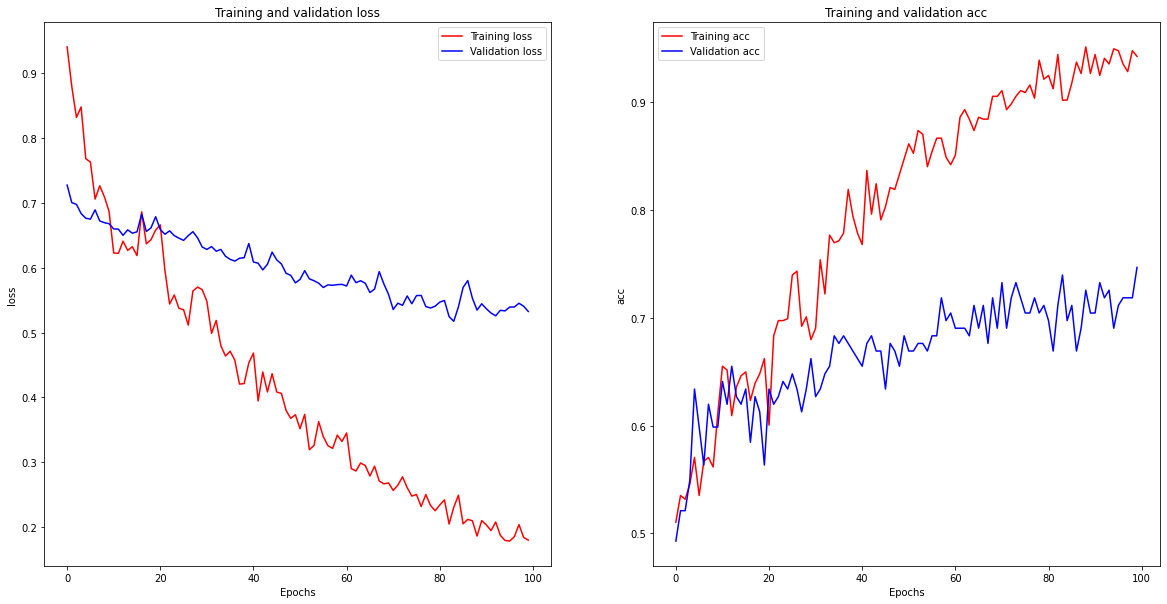

In [55]:
#Plot training loss and accuracy 
training_plots(fittedmodel, epochs = n_epochs)

### Step 4: Evaluate the model on the test set 

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
def test(model, X_test, Y_test, filename):
    model.load_weights(filename+'Rand42.h5')
    probs = model.predict(X_test)
    preds = probs.argmax(axis = 1)  
    acc = np.mean(preds == Y_test)
    
    return acc, preds

In [58]:
accuracy, predictions = test(model, X_test, Y_test, 'EEG_ConvNettask3')

In [59]:
print('Classification accuracy on test set is: {0:.3f}'.format(accuracy))

Classification accuracy on test set is: 0.730


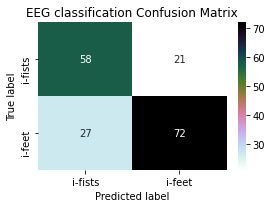

In [60]:
import pandas as pd
import seaborn as sns

labels = ['i-fists', 'i-feet']
cm = confusion_matrix(Y_test, predictions)

cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)
plt.rcParams["figure.figsize"] = (4,3)
fig = plt.figure()
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('EEG classification Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()